# Classificador de tênis (Nike vs Adidas)

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import seaborn as sns
import numpy as np
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

## Carregamento de dados dos datasets.

In [2]:
from sklearn.model_selection import train_test_split

def datasetLoader(data_dir, batch_size):
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
    train_dir = os.path.join(data_dir, "Training")
    train_data = ImageFolder(root=train_dir, transform=transform)

    train_indices, test_indices = train_test_split(
        range(len(train_data)), test_size=0.33, random_state=42
    )

    train_subset = Subset(train_data, train_indices)
    test_subset = Subset(train_data, test_indices)

    training_loader = DataLoader(
        train_subset, batch_size=batch_size, shuffle=True
    )

    test_loader = DataLoader(
        test_subset, batch_size=batch_size, shuffle=False
    )

    return training_loader, test_loader

In [3]:
data_dir = "Dataset"
train_loader, test_loader = datasetLoader(data_dir, batch_size=12)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
print(f"Número total de amostras: {len(test_loader.dataset)+len(train_loader.dataset)}")
print(f"Número de amostras de treinamento: {len(train_loader.dataset)}")
print(f"Número de amostras de teste: {len(test_loader.dataset)}")

Número total de amostras: 564
Número de amostras de treinamento: 377
Número de amostras de teste: 187


 O dropout será ativado entre a camada convolucional final da ResNet50 e a camada linear que produzirá a saída final do modelo. Durante o treinamento, o dropout aleatoriamente "desliga" neurônios, reduzindo a dependência entre eles, o que ajuda a prevenir o overfitting. Dropout ajudou muito para diminuir a valor da função custo de validação.

In [5]:
resnet = torchvision.models.resnet50(weights = True)
resnet.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.6),  # Adicionando dropout com probabilidade 0.5
    torch.nn.Linear(2048, 2)
)
resnet = resnet.to(device)

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Métodos 

### Matriz de confusão

In [6]:
def confusion_matrix(model, loader):
    model.eval()
    confusion_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            for i in range(labels.size(0)):
                confusion_matrix[labels[i].item()][predicted[i].item()] += 1
    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['Adidas', 'Nike'], yticklabels=['Adidas', 'Nike'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Label')
    return ax

### Acurácia

In [7]:
def accuracy(model, loader):
    model.eval()
    corrected = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs, 1)
            total += labels.size(0)
            corrected += (predicted == labels).sum().item()
    return corrected * 100 // total

### F1 Score

In [8]:
from sklearn.metrics import f1_score

def calculate_f1_score(model, loader):
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    return f1_score(true_labels, predicted_labels, average='macro')

### ROC AUC métrica

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def calculate_roc_auc_score(model, loader, n_classes):
    model.eval()
    true_labels = []
    predicted_probs = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_probs.extend(probs.cpu().numpy())
    true_labels = label_binarize(true_labels, classes=[i for i in range(n_classes)])
    return roc_auc_score(true_labels, predicted_probs, multi_class='ovr')

### Validação

In [10]:
def validation(model, loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs,labels)
            val_loss += loss.item()
    return val_loss/len(loader)

### Regularização

l1_lambda e l2 lambda são os pesos/intensidade que a regularização aplicará no modelo.

In [11]:
def l1_regularization(model, l1_lambda, device):
    l1_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L1 dos parâmetros e somando-as
        l1_reg += torch.norm(param, 1)
    # Multiplicando pela lambda para obter o termo de regularização L1
    return l1_lambda * l1_reg

In [12]:
def l2_regularization(model, l2_lambda, device):
    l2_reg = torch.tensor(0., device=device)
    for param in model.parameters():
        # Calculando a norma L2 dos parâmetros e somando suas raízes quadradas
        l2_reg += torch.norm(param, 2) ** 2
    # Multiplicando pela lambda e raiz quadrada para obter o termo de regularização L2
    return l2_lambda * torch.sqrt(l2_reg)

### Treinamento

In [13]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train(model, trainloader, testloader, optimizer, criterion, epochs, l1_lambda, l2_lambda, device, lr_patience, early_stop_patience):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    lr_scheduler = ReduceLROnPlateau(optimizer, patience=lr_patience, verbose=True)  # Se a perda de validação não melhorar por x épocas, reduz a taxa de aprendizado em 0,1

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for data in tqdm(trainloader):
            images, labels = data
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            l1_reg = l1_regularization(model, l1_lambda, device)    ##  L1 e L2 regularization  ##
            l2_reg = l2_regularization(model, l2_lambda, device)    ##  L1 e L2 regularization  ##     
            loss += l1_reg + l2_reg                                 ##  L1 e L2 regularization  ##
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        val_loss = validation(model, testloader, criterion)
        lr_scheduler.step(val_loss)                                 ##  Learning Rate Scheduler  ##
        train_losses.append(running_loss/len(trainloader))
        val_losses.append(val_loss)
        print(f'Epoch: {epoch+1} | Train Loss: {train_losses[-1]} | Val Loss: {val_loss}')

        if val_loss < best_val_loss:                                ##  Early Stopping  ##
            best_val_loss = val_loss                                
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stop_patience:
                print(f'Parada antecipada na época {epoch+1}, pois a loss na validação não apresentou melhora.')
                break
        
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

## Registro de evoluções nos modelos
- 1º modelo era treinado com apenas 3 épocas e com learning rate de 0,001. **Acurácia de 70%**.
- 2º modelo subimos o número de épocas para 30 (número baseado nos modelos analisados da referência 1) e ajustamos o learning rate para 0,0001. **Acurácia de 88%**.
- 3º modelo inserimos regularização L1 e L2 com peso da regularização de 0,01. **Acurácia caiu para 76%**
- 4º modelo ajustamos os parâmetros de pesos da regularização L1 e L2 para de 0,00001. **Acurácia de 90%**

Referências:  
1 - https://www.kaggle.com/datasets/ifeanyinneji/nike-adidas-shoes-for-image-classification-dataset/code

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
l1_lambda = 0.001
l2_lambda = 0.01
epochs = 60 
lr_patience = 3
early_stop_patience = 5

## Treinamento

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
 66%|██████▌   | 21/32 [00:07<00:03,  3.06it/s]c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 32/32 [00:11<00:00,  2.73it/s]


Epoch: 1 | Train Loss: 253.15529108047485 | Val Loss: 0.2911611828021705


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Epoch: 2 | Train Loss: 209.0751223564148 | Val Loss: 0.16827064217068255


100%|██████████| 32/32 [00:10<00:00,  3.05it/s]


Epoch: 3 | Train Loss: 171.64255619049072 | Val Loss: 0.6637426344677806


100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Epoch: 4 | Train Loss: 142.18351984024048 | Val Loss: 0.18601753027178347


100%|██████████| 32/32 [00:10<00:00,  3.04it/s]


Epoch: 5 | Train Loss: 119.09295177459717 | Val Loss: 0.20261957123875618


100%|██████████| 32/32 [00:10<00:00,  3.00it/s]


Epoch: 6 | Train Loss: 100.90126824378967 | Val Loss: 0.15784176089800894


100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Epoch: 7 | Train Loss: 87.34563040733337 | Val Loss: 0.3994620987214148


100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Epoch: 8 | Train Loss: 76.22107434272766 | Val Loss: 0.1675305941607803


100%|██████████| 32/32 [00:10<00:00,  3.01it/s]


Epoch: 9 | Train Loss: 66.46569895744324 | Val Loss: 0.19184083444997668


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch: 10 | Train Loss: 59.34426486492157 | Val Loss: 0.33960155583918095


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch: 11 | Train Loss: 56.3218275308609 | Val Loss: 0.15448271471541375


100%|██████████| 32/32 [00:10<00:00,  2.99it/s]


Epoch: 12 | Train Loss: 54.73911738395691 | Val Loss: 0.1137368297931971


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch: 13 | Train Loss: 53.67546045780182 | Val Loss: 0.12625666748499498


100%|██████████| 32/32 [00:10<00:00,  2.97it/s]


Epoch: 14 | Train Loss: 52.81313729286194 | Val Loss: 0.11377403889491688


100%|██████████| 32/32 [00:10<00:00,  2.98it/s]


Epoch: 15 | Train Loss: 52.10598385334015 | Val Loss: 0.12463938957080245


100%|██████████| 32/32 [00:10<00:00,  2.93it/s]


Epoch: 16 | Train Loss: 51.449695110321045 | Val Loss: 0.12188132814480923


100%|██████████| 32/32 [00:10<00:00,  2.95it/s]


Epoch: 17 | Train Loss: 51.053887486457825 | Val Loss: 0.12548461588448845
Parada antecipada na época 17, pois a loss na validação não apresentou melhora.


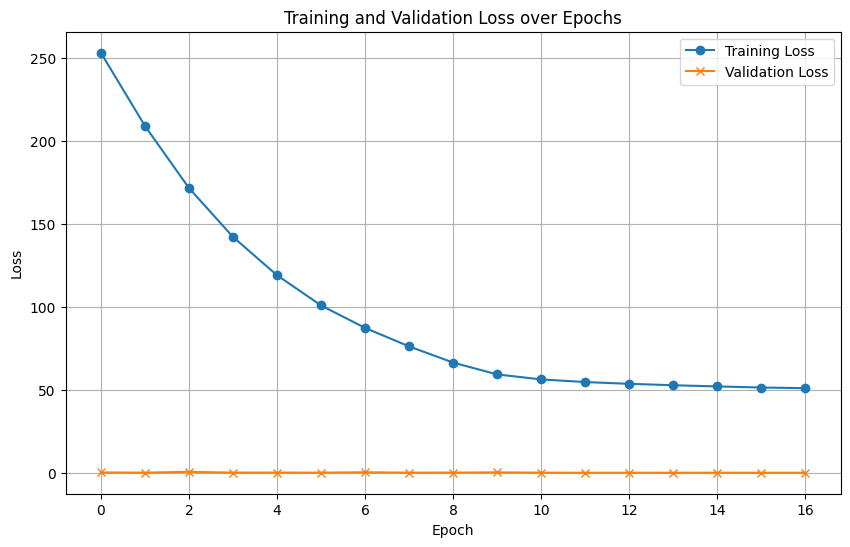

In [15]:
train(resnet, train_loader, test_loader, optimizer, criterion, epochs=epochs, l1_lambda=l1_lambda, l2_lambda=l2_lambda, device=device, lr_patience=lr_patience, early_stop_patience=early_stop_patience)

In [16]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Métricas de avaliação

### Recall

A rede atinge: 95% de acurácia
A rede atinge: 95.72% de recall
A rede atinge: 99.29% de ROC AUC Score


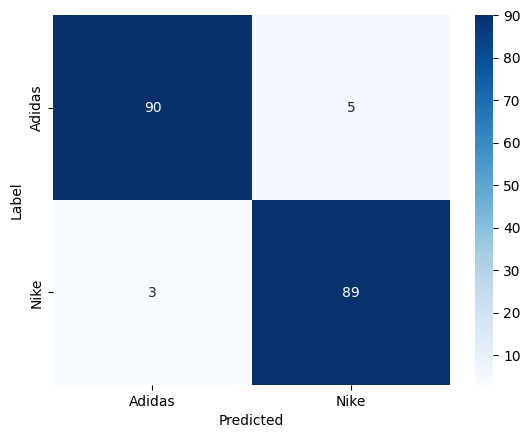

In [17]:
print(f'A rede atinge: {accuracy(resnet, test_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, test_loader)*100,2)}% de recall')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, test_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, test_loader)

c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


A rede atinge: 100% de acurácia
A rede atinge: 100.0% de recall


c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


A rede atinge: 100.0% de ROC AUC Score


c:\Users\guilh\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


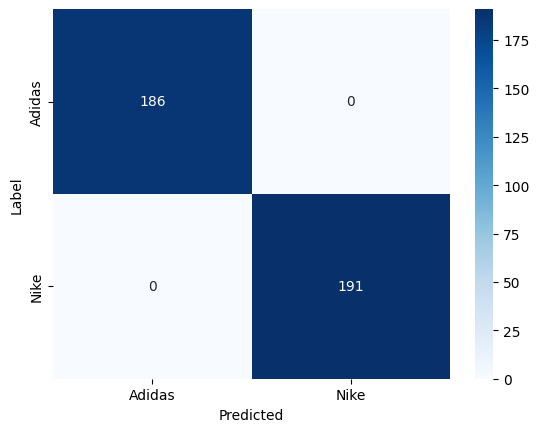

In [18]:
print(f'A rede atinge: {accuracy(resnet, train_loader)}% de acurácia')
print(f'A rede atinge: {round(calculate_f1_score(resnet, train_loader)*100,2)}% de recall')
print(f'A rede atinge: {round(calculate_roc_auc_score(resnet, train_loader, 50)*100,2)}% de ROC AUC Score')
conf_mat = confusion_matrix(resnet, train_loader)

In [19]:
torch.save(resnet.state_dict(), 'model.pth')

## Usabilidade de webcam

In [20]:
import cv2

cap = cv2.VideoCapture(0)

img_counter = 0

while True:
    ret, frame = cap.read()
    cv2.imshow('Webcam', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    elif cv2.waitKey(1) & 0xFF == ord('e'):
            img_name = "WebcamImages/print_{}.png".format(img_counter)
            cv2.imwrite(img_name, frame)
            print("{} written!".format(img_name))
            img_counter += 1

cap.release()
cv2.destroyAllWindows()

### Predição

In [21]:
def predict(model, image):
    prediction = model(torch.unsqueeze(image, 0).to(device))
    result = torch.argmax(prediction)
    return 'Adidas' if result == 0 else 'Nike'

### Predição das classes da webcam

In [27]:
cnn = torch.load('model.pth')
resnet.load_state_dict(cnn)
from PIL import Image
for filename in os.listdir('WebcamImages'):
    if filename.endswith(".png"):
        x = Image.open('WebcamImages/' + filename).convert('RGB')
        x = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])(x)
        print(f'Image: {filename} | Resnet Prediction: {predict(resnet, x)}')

Image: teste_0.png | Resnet Prediction: Adidas
Image: teste_1.png | Resnet Prediction: Nike
Image: teste_2.png | Resnet Prediction: Nike
